In [1038]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from datetime import date

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import zscore
from pmdarima import auto_arima
import math
import pmdarima as pm
from unidecode import unidecode

import warnings
from sklearn.ensemble import IsolationForest
# Suppress warnings
warnings.filterwarnings("ignore")


## 1.1. Data collection

In [1039]:
file_path = 'data/vietnam_macro_economic_by_month.csv'
data = pd.read_csv(file_path)
data.head()

,Thời gian,FDI,FDI đăng kí (lũy kế năm),FDI giải ngân (lũy kế năm),Thương mại (lũy kế năm),Xuất khẩu (lũy kế năm),Nhập khẩu (lũy kế năm),Cung tiền & tín dụng,Tăng trưởng tín dụng,Nông nghiệp,...,Chi thường xuyên,Chỉ số giá,Lạm phát cơ bản,Lạm phát,Thực phẩm,Nhà ở và VLXD,Y tế,Vận tải,Chỉ số PMI,Tăng trưởng GDP thực tế
0,-,-,% YoY,% YoY,-,% YoY,% YoY,-,% YoY,% YoY,...,% YoY,-,% YoY,% YoY,% YoY,% YoY,% YoY,% YoY,-,% YoY
1,T1 2017,-,19,6.3,-,6,3.2,-,19.5,17.7,...,NaN,-,1.9,5.2,2.4,3.5,79.4,5,51.9,5.2
2,T2 2017,-,21.5,3.3,-,16.5,23.5,-,19.6,17.5,...,NaN,-,1.5,5,-0.3,4.8,79.8,10,54.2,5.2
3,T3 2017,-,91.5,3.4,-,15.7,25.4,-,21.6,17.9,...,NaN,-,1.6,4.7,-0.9,5.3,48.7,14.6,54.6,5.2
4,T4 2017,-,53.9,3.2,-,17.4,24.8,-,20.6,17.8,...,NaN,-,1.5,4.3,-1.7,4.3,63.6,11.1,54.1,6.4


## 1.2. Data Preprocessing

### 1.2.1. Clean columns

In [1040]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [1041]:
columns = ['Thoi_gian', 'FDI', 'FDI_dang_ki',
       'FDI_giai_ngan', 'Thuong_mai_luy_ke_nam',
       'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te']

data.columns = columns

print("Column names after cleaning:", data.columns)

Column names after cleaning: Index(['Thoi_gian', 'FDI', 'FDI_dang_ki', 'FDI_giai_ngan',
       'Thuong_mai_luy_ke_nam', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te'],
      dtype='object')


In [1042]:
selected_columns = ['Thoi_gian', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
data = data[selected_columns]

# Drop hàng thứ 2 (hàng chứa thông tin về đơn vị)
data = data.drop(0)

data.head()
data.shape

(84, 8)

### 1.2.2. Convert date format

In [1043]:
def convert_date(date_str):
    month_map = {
        'T1': '01', 'T2': '02', 'T3': '03', 'T4': '04', 'T5': '05',
        'T6': '06', 'T7': '07', 'T8': '08', 'T9': '09', 'T10': '10',
        'T11': '11', 'T12': '12'
    }
    month, year = date_str.split()
    month = month_map[month]
    return pd.to_datetime(f'{year}-{month}-01')


time_column = 'Thoi_gian'
data[time_column] = data[time_column].apply(convert_date)

data[time_column] = pd.to_datetime(data[time_column])
data.set_index(time_column, inplace=True)

data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19,6,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17,4.3,6.4
2017-05-01,19.4,19,25.3,22,16.2,3.2,6.4


### 1.2.3. Handle missing value

In [1044]:
data.isna().sum()

FDI_dang_ki                0
Xuat_khau_luy_ke_nam       5
Nhap_khau_luy_ke_nam       2
Tang_truong_tin_dung       0
Cung_tien_M2               0
Lam_phat                   0
Tang_truong_GDP_thuc_te    0
dtype: int64

In [1045]:
xuat_khau = 'Xuat_khau_luy_ke_nam'
nhap_khau = 'Nhap_khau_luy_ke_nam'

data[xuat_khau] = data[xuat_khau].replace({None: np.nan, '': np.nan})
data[nhap_khau] = data[nhap_khau].replace({None: np.nan, '': np.nan})

data[xuat_khau] = pd.to_numeric(data[xuat_khau], errors='coerce')
data[nhap_khau] = pd.to_numeric(data[nhap_khau], errors='coerce')

# xử lí những giá trị null trong cột xuất khẩu và nhập khẩu bằng nội suy tuyến tính
data[xuat_khau] = data[xuat_khau].interpolate(method='linear')
data[nhap_khau] = data[nhap_khau].interpolate(method='linear')

missing_values = data.isna().sum()
missing_values[missing_values > 0]
data = data.astype(float)

### 1.2.4. Detect outlier

In [1046]:
model = IsolationForest(n_estimators=150, contamination=0.3)
model.fit(data)
y_anomaly = model.predict(data)
data[y_anomaly == -1] = np.median(data, axis=0)

### 1.2.5. Stationarity

#### Plot time series and check for trends or seasonality with mean and varience

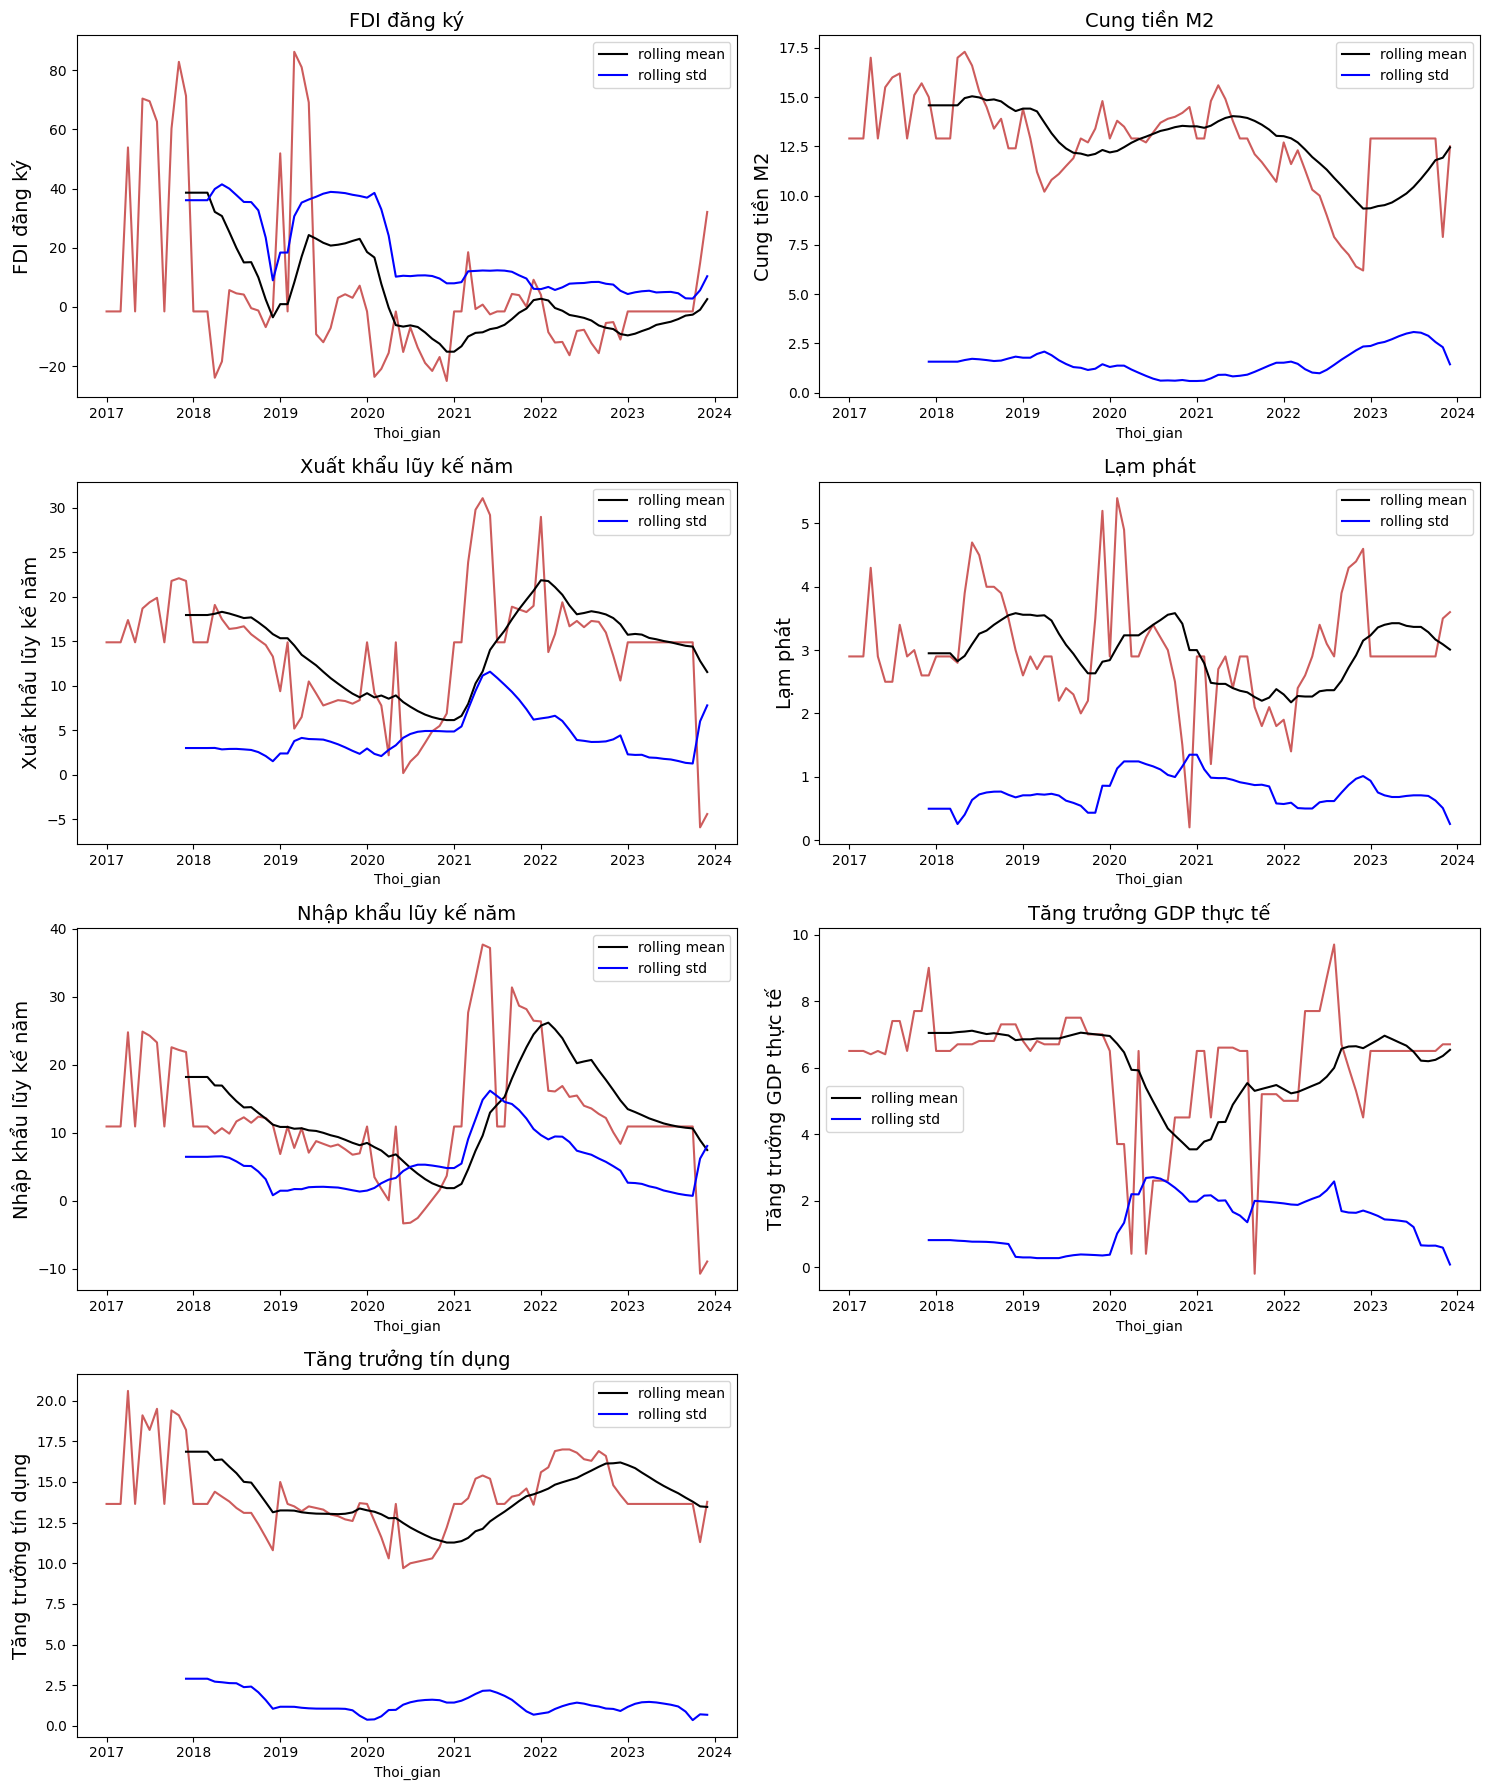

In [1047]:
def plot_time_series(ax, x, y, rolling_window, title, ylabel, color='indianred'):
    sns.lineplot(x=x, y=y, ax=ax, color=color)
    sns.lineplot(x=x, y=y.rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
    sns.lineplot(x=x, y=y.rolling(rolling_window).std(), ax=ax, color='blue', label='rolling std')
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

rolling_window = 12  # Đặt giá trị phù hợp với dữ liệu (12 tháng = 1 năm)
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

plot_time_series(ax[0, 0], data.index, data.FDI_dang_ki, rolling_window, 'FDI đăng ký', 'FDI đăng ký')
plot_time_series(ax[1, 0], data.index, data.Xuat_khau_luy_ke_nam, rolling_window, 'Xuất khẩu lũy kế năm', 'Xuất khẩu lũy kế năm')
plot_time_series(ax[2, 0], data.index, data.Nhap_khau_luy_ke_nam, rolling_window, 'Nhập khẩu lũy kế năm', 'Nhập khẩu lũy kế năm')
plot_time_series(ax[3, 0], data.index, data.Tang_truong_tin_dung, rolling_window, 'Tăng trưởng tín dụng', 'Tăng trưởng tín dụng')
plot_time_series(ax[0, 1], data.index, data.Cung_tien_M2, rolling_window, 'Cung tiền M2', 'Cung tiền M2')
plot_time_series(ax[1, 1], data.index, data.Lam_phat, rolling_window, 'Lạm phát', 'Lạm phát')
plot_time_series(ax[2, 1], data.index, data.Tang_truong_GDP_thuc_te, rolling_window, 'Tăng trưởng GDP thực tế', 'Tăng trưởng GDP thực tế')

f.delaxes(ax[3, 1])  # Remove empty plot if exists

plt.tight_layout()
plt.show()


Chúng ta có thể thấy rằng tất cả các feature đều có phương sai trung bình và  hằng số thay đổi theo thời gian.  
Nếu như quan sát bằng những biểu đồ này, không cái nào trong số này có tính dừng.   

#### Augmented Dickey-Fuller (ADF) test

Forest Green: Strong evidence that the series is stationary (ADF statistic is less than the 1% critical value).     
Gold: Moderate evidence that the series is stationary (ADF statistic is less than the 5% critical value).   
Orange: Weak evidence that the series is stationary (ADF statistic is less than the 10% critical value).    
Indian Red: Evidence that the series is non-stationary. 

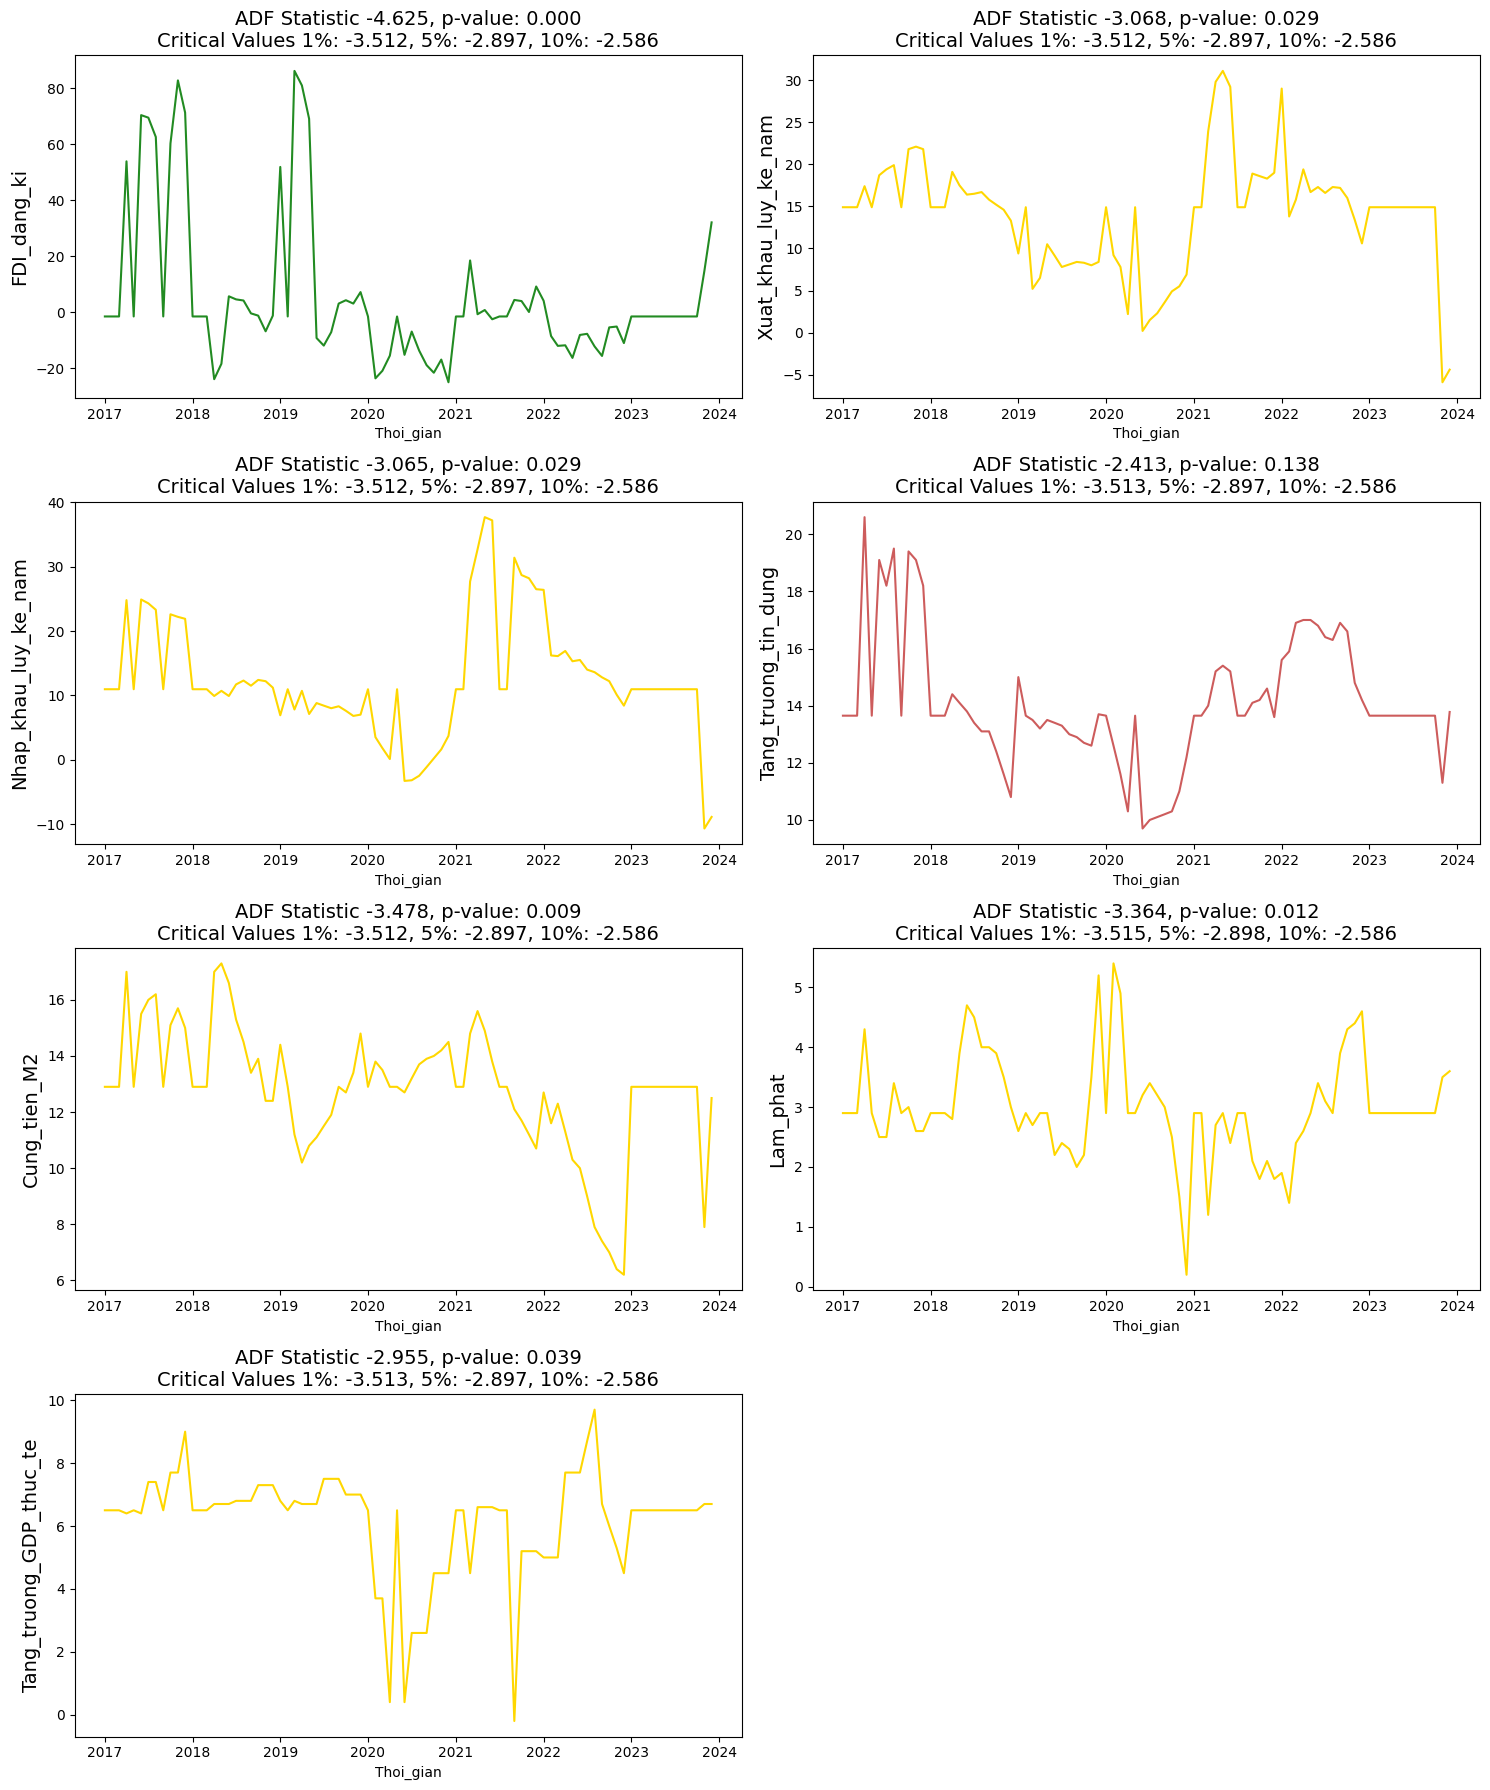

In [1048]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series) # check adf
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

columns = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 
           'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    visualize_adfuller_results(data[column], column, ax[row, col])

# Remove empty subplots if has
if len(columns) % 2 != 0:
    f.delaxes(ax[len(columns) // 2, 1])

plt.tight_layout()
plt.show()


Chúng ta có thể thấy rằng ngoài 2 feature là FDI_dang_ki và Tang_truong_GDP thực tế thì không có feature nào có tính dừng

### 1.2.4. Differencing

#### Thực hiện lấy sai phân cho feature không có tính dừng : Cung tiền M2

In [1049]:
# # First Order Differencing
# ts_diff = np.diff(data.Lam_phat)
# data['Lam_phat_diff_1'] = np.append([0], ts_diff)

# # Second Order Differencing
# ts_diff = np.diff(data.Lam_phat)
# data['Lam_phat_diff_2'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# visualize_adfuller_results(data.Lam_phat_diff_1, 'Differenced (1. Order) \n Cung tien M2', ax[0])
# visualize_adfuller_results(data.Lam_phat_diff_2, 'Differenced (2. Order) \n Cung tien M2', ax[1])
# plt.tight_layout()
# plt.show()

In [1050]:
# # First Order Differencing
# ts_diff = np.diff(data.Cung_tien_M2)
# data['Cung_tien_M2_diff_1'] = np.append([0], ts_diff)

# # Second Order Differencing
# ts_diff = np.diff(data.Cung_tien_M2)
# data['Cung_tien_M2_diff_2'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# visualize_adfuller_results(data.Cung_tien_M2_diff_1, 'Differenced (1. Order) \n Cung tien M2', ax[0])
# visualize_adfuller_results(data.Cung_tien_M2_diff_2, 'Differenced (2. Order) \n Cung tien M2', ax[1])
# plt.tight_layout()
# plt.show()

#### Thực hiện lấy sai phân cho feature không có tính dừng : Nhập khẩu lũy kế năm

In [1051]:
# # First Order Differencing
# ts_diff = np.diff(data.Nhap_khau_luy_ke_nam)
# data['Nhap_khau_luy_ke_nam_diff_1'] = np.append([0], ts_diff)

# # Second Order Differencing
# ts_diff = np.diff(data.Nhap_khau_luy_ke_nam)
# data['Nhap_khau_luy_ke_nam_diff_2'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# visualize_adfuller_results(data.Nhap_khau_luy_ke_nam_diff_1, 'Differenced (1. Order) \n Nhap khau luy ke nam', ax[0])
# visualize_adfuller_results(data.Nhap_khau_luy_ke_nam_diff_2, 'Differenced (2. Order) \n Nhap khau luy ke nam', ax[1])
# plt.tight_layout()
# plt.show()

#### Thực hiện lấy sai phân cho feature không có tính dừng : Xuất khẩu lũy kế năm

In [1052]:
# # First Order Differencing
# ts_diff = np.diff(data.Xuat_khau_luy_ke_nam)
# data['Xuat_khau_luy_ke_nam_diff_1'] = np.append([0], ts_diff)

# # Second Order Differencing
# ts_diff = np.diff(data.Xuat_khau_luy_ke_nam)
# data['Xuat_khau_luy_ke_nam_diff_2'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# visualize_adfuller_results(data.Xuat_khau_luy_ke_nam_diff_1, 'Differenced (1. Order) \n Xuat khau luy ke nam', ax[0])
# visualize_adfuller_results(data.Xuat_khau_luy_ke_nam_diff_2, 'Differenced (2. Order) \n Xuat khau luy ke nam', ax[1])
# plt.tight_layout()
# plt.show()

#### Thực hiện lấy sai phân cho feature không có tính dừng : Tăng trưởng tín dụng

In [1053]:
# # First Order Differencing
# ts_diff = np.diff(data.Tang_truong_tin_dung)
# data['Tang_truong_tin_dung_diff_1'] = np.append([0], ts_diff)

# # Second Order Differencing
# ts_diff = np.diff(data.Tang_truong_tin_dung)
# data['Tang_truong_tin_dung_diff_2'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# visualize_adfuller_results(data.Tang_truong_tin_dung_diff_1, 'Differenced (1. Order) \n Tang truong tin dung', ax[0])
# visualize_adfuller_results(data.Tang_truong_tin_dung_diff_2, 'Differenced (2. Order) \n Tang truong tin dung', ax[1])
# plt.tight_layout()
# plt.show()

#### Thêm các columns sau khi lấy sai phân vào table

In [1054]:
# data.Cung_tien_M2.equals(data.Cung_tien_M2_diff_1.cumsum() + data.Cung_tien_M2.iloc[0])
# data.Nhap_khau_luy_ke_nam.equals(data.Nhap_khau_luy_ke_nam_diff_1.cumsum() + data.Nhap_khau_luy_ke_nam.iloc[0])
# data.Xuat_khau_luy_ke_nam.equals(data.Xuat_khau_luy_ke_nam_diff_1.cumsum() + data.Xuat_khau_luy_ke_nam.iloc[0])
# data.Tang_truong_tin_dung.equals(data.Tang_truong_tin_dung_diff_1.cumsum() + data.Tang_truong_tin_dung.iloc[0])

## 1.3. Feature Engineering

## 1.4. EDA

### 1.4.1. Correlation Matrix

In [1055]:
# plt.figure(figsize=(12,10))

# shifted_cols = ['Tang_truong_GDP_thuc_te_seasonal', 'FDI_dang_ki_seasonal', 'Xuat_khau_luy_ke_nam_diff_1_seasonal', 'Nhap_khau_luy_ke_nam_diff_1_seasonal',
#        'Tang_truong_tin_dung_diff_1_seasonal', 'Cung_tien_M2_diff_1_seasonal', 'Lam_phat_transformed']
# corrmat = data[shifted_cols].corr()

# sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')
# plt.title('Correlation Matrix of Shifted Features', fontsize=16)

# plt.tight_layout()
# plt.show()

Nhận thấy, ngoại trừ FDI_dang_ki và Tang_truong_GDP_thuc_te (target variable), không có sự tương quan nào quá lớn

##

### 1.4.2. Auto correlation

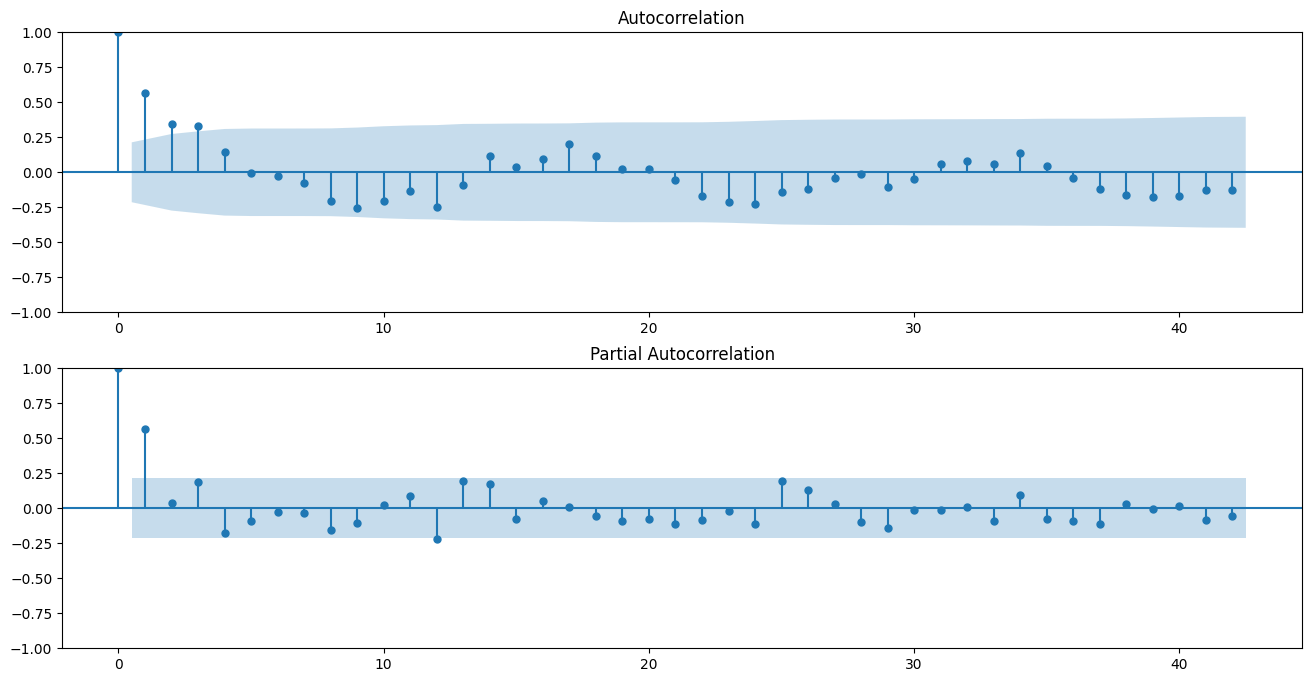

In [1056]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Lam_phat,lags=42, ax=ax[0])
plot_pacf(data.Lam_phat,lags=42, ax=ax[1])
plt.show()

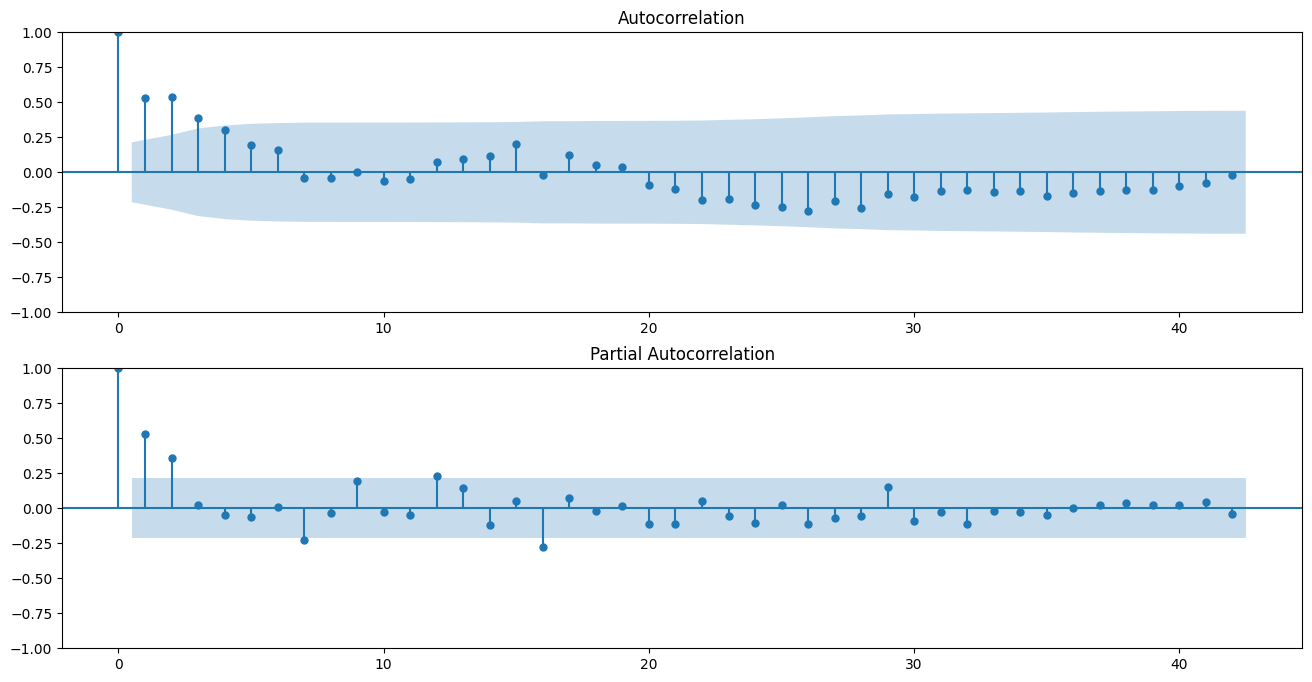

In [1057]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[0])
plot_pacf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[1])
plt.show()

In [1058]:
train_data = data['2017-01-01':'2021-04-01']
test_data = data['2021-05-01':'2023-12-01']
target_1 = 'Lam_phat'
y_train_1 = train_data[target_1]
y_test_1 = test_data[target_1]

target_2 = 'Tang_truong_GDP_thuc_te'
y_train_2 = train_data[target_2]
y_test_2 = test_data[target_2]

## 1.6. Model

In [1059]:
model = ARIMA(y_train_1, order=(3, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

forecast_1 = model_fit.forecast(steps=len(y_test_1)) 
forecast_1 = forecast_1.rename('Forecast_1')
mape_lamphat = np.mean(np.abs(forecast_1 - y_test_1)/np.abs(y_test_1))

                               SARIMAX Results                                
Dep. Variable:               Lam_phat   No. Observations:                   52
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 -58.790
Date:                Thu, 23 May 2024   AIC                            131.579
Time:                        14:07:09   BIC                            145.238
Sample:                    01-01-2017   HQIC                           136.816
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0136      0.320      9.404      0.000       2.386       3.642
ar.L1          0.1608      0.212      0.758      0.448      -0.255       0.576
ar.L2         -0.6934      0.185     -3.744      0.0

In [1060]:
model = ARIMA(y_train_2, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

forecast_2 = model_fit.forecast(steps=len(y_test_2)) 
forecast_2 = forecast_2.rename('Forecast_2')
mape_gdp = np.mean(np.abs(forecast_2 - y_test_2)/np.abs(y_test_2))

                                  SARIMAX Results                                  
Dep. Variable:     Tang_truong_GDP_thuc_te   No. Observations:                   52
Model:                      ARIMA(1, 0, 1)   Log Likelihood                 -86.453
Date:                     Thu, 23 May 2024   AIC                            180.905
Time:                             14:07:09   BIC                            188.710
Sample:                         01-01-2017   HQIC                           183.897
                              - 04-01-2021                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1179      1.287      4.753      0.000       3.595       8.641
ar.L1          0.8854      0.087     10.235      0.000       0.716       1.055
ma.L1       

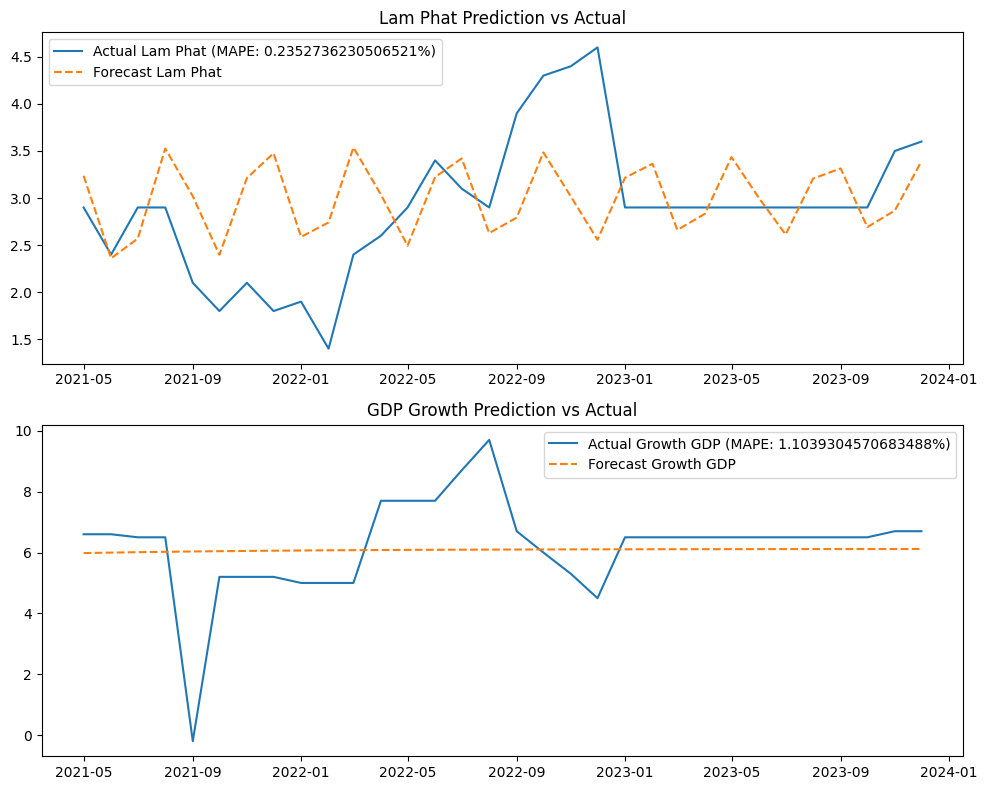

In [1061]:
# Create a figure and two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot for Lam Phat
ax[0].plot(y_test_1, label=f'Actual Lam Phat (MAPE: {mape_lamphat}%)')
ax[0].plot(forecast_1, label='Forecast Lam Phat', linestyle='--')
ax[0].legend()
ax[0].set_title('Lam Phat Prediction vs Actual')

# Plot for GDP Growth
ax[1].plot(y_test_2, label=f'Actual Growth GDP (MAPE: {mape_gdp}%)')
ax[1].plot(forecast_2, label='Forecast Growth GDP', linestyle='--')
ax[1].legend()
ax[1].set_title('GDP Growth Prediction vs Actual')

# Show the plot
plt.tight_layout()
plt.show()